In [6]:
import pandas as pd
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
import pickle
import os.path

def get_google_sheet_data(spreadsheet_id, range_name):
    """
    Read data from a private Google Sheet using OAuth2 authentication.
    
    Parameters:
    spreadsheet_id (str): The ID of the spreadsheet (from the URL)
    range_name (str): The range to read (e.g., 'Sheet1!A1:D10')
    
    Returns:
    pandas.DataFrame: The sheet data as a DataFrame
    """
    # If modifying these scopes, delete the token.pickle file
    SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
    creds = None

    # Load existing credentials from token.pickle
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)

    # If credentials don't exist or are invalid, get new ones
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # Load client secrets from your downloaded credentials file
            flow = InstalledAppFlow.from_client_secrets_file(
                '../resources/credentials.json',  # Download this from Google Cloud Console
                SCOPES
            )
            creds = flow.run_local_server(port=0)
            
        # Save credentials for future use
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    # Build the Sheets API service
    service = build('sheets', 'v4', credentials=creds)

    try:
        # Call the Sheets API to get the data
        sheet = service.spreadsheets()
        result = sheet.values().get(
            spreadsheetId=spreadsheet_id,
            range=range_name
        ).execute()
        
        values = result.get('values', [])
        
        if not values:
            raise ValueError('No data found in the specified range.')
            
        # Convert to DataFrame
        df = pd.DataFrame(values[1:], columns=values[0])
        
        return df
        
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import json

with open("./google-sheet.json") as f:
    workbook407 = json.load(f)


# IST407 Grades

In [15]:

current_date = datetime.now().strftime('%Y-%m-%d')
print(f"Last update: {current_date}")

Last update: 2025-02-03


## Participation Grades

In [16]:
roster = get_google_sheet_data(workbook407['id'],workbook407['roster'])[['github_id','public_id']]
participation_grades= get_google_sheet_data(workbook407['id'],workbook407['participation'])

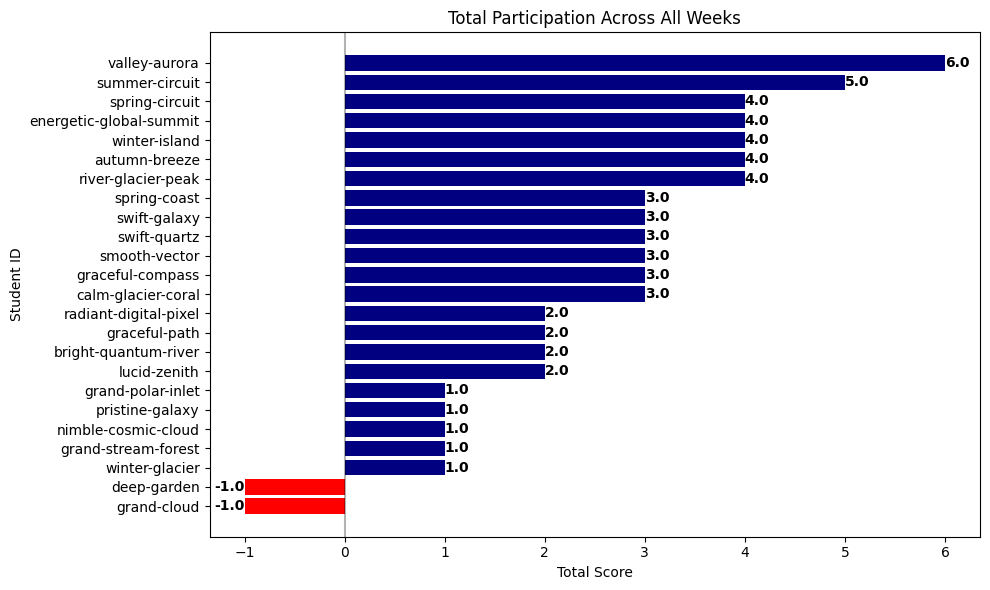

In [22]:
week_columns = [col for col in participation_grades if col.startswith('Week')]
final_participation = participation_grades.merge(roster,on="github_id").drop("github_id",axis=1)
final_participation['total_score'] = final_participation[week_columns].astype(float).sum(axis=1)
final_participation.sort_values('total_score',inplace=True)
final_participation

plt.figure(figsize=(10,6))

# Create horizontal bars with different colors for positive/negative
colors = ['red' if x < 0 else 'navy' for x in final_participation['total_score']]
bars = plt.barh(final_participation['public_id'], final_participation['total_score'], color=colors)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             ha='left' if width >= 0 else 'right',
             va='center',
             fontweight='bold')

plt.title('Total Participation Across All Weeks')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()

## Weekly Exercise Grades

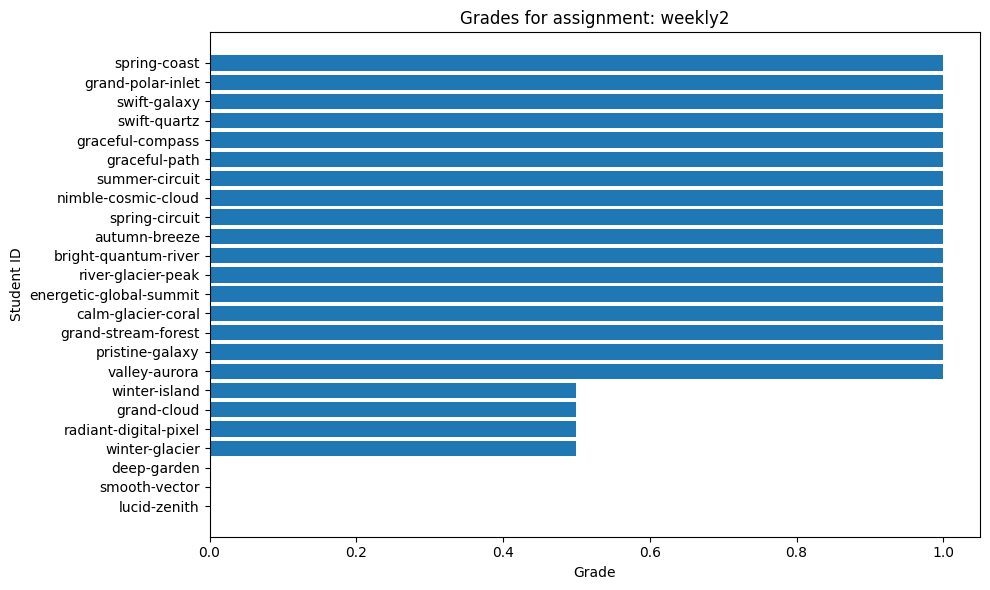

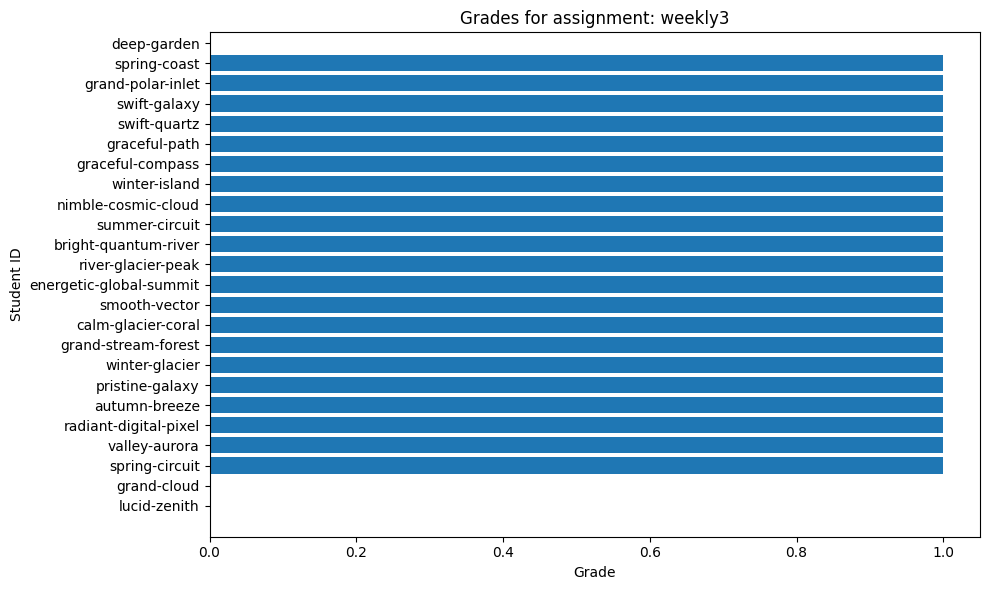

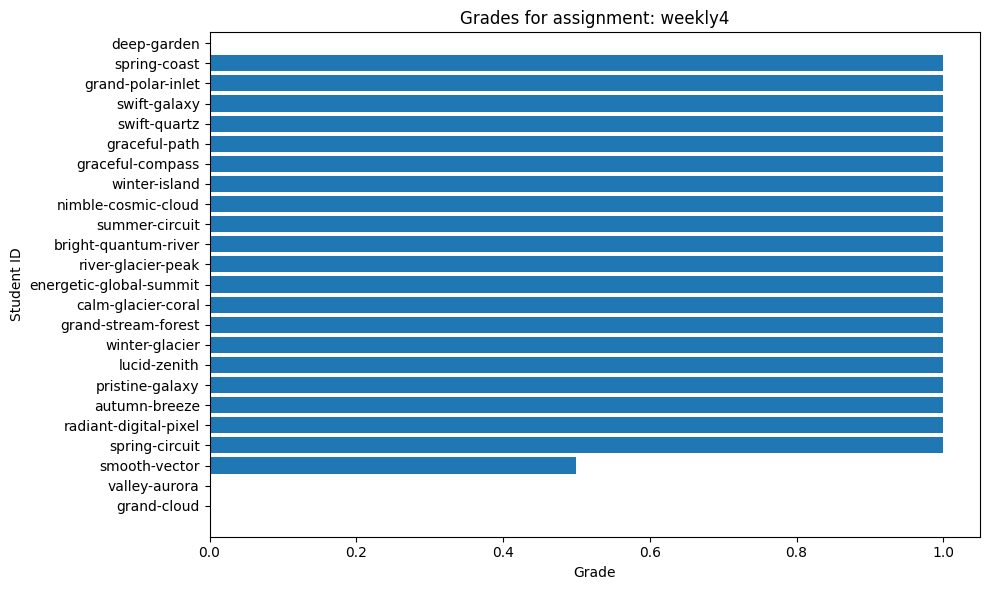

In [23]:
weekly_grades = pd.read_csv("../IST407/grades/SU-IST407-SP25/master/all_weekly_grades.csv")
final_weekly = weekly_grades.merge(roster,left_on="Student",right_on="github_id").drop(["Student","github_id"],axis=1)
for col in [x for x in weekly_grades.columns if x!="Student"]:
    df = final_weekly.sort_values(col)  # Changed to True for better readability
    plt.figure(figsize=(10,6))  # Added to make labels more readable
    plt.barh(df["public_id"], df[col])
    plt.title(f"Grades for assignment: {col}")
    plt.xlabel("Grade")
    plt.ylabel("Student ID")
    plt.tight_layout()  # Added to prevent label cutoff
    plt.show()


### Weekly grade summary

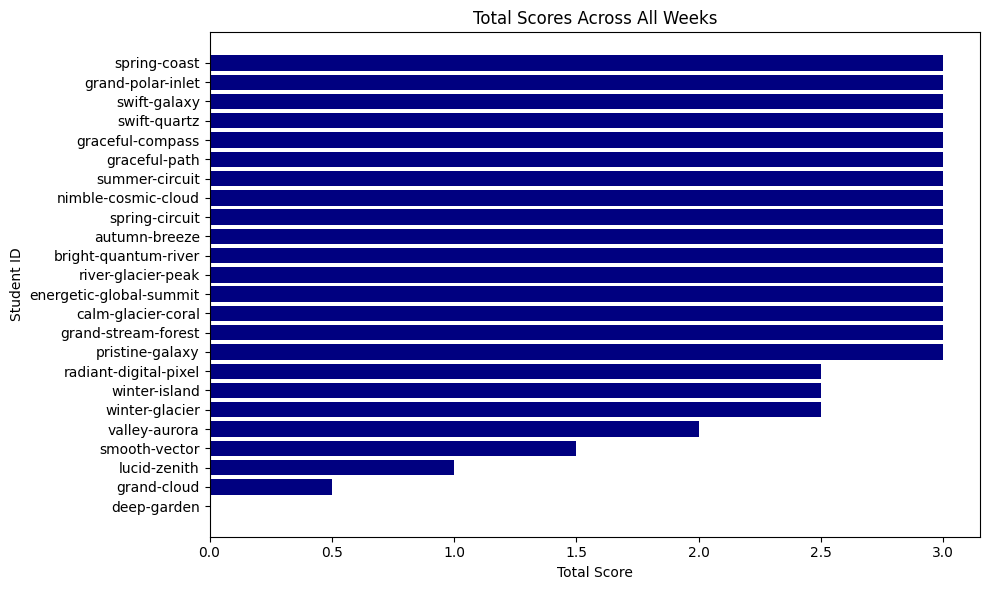

In [24]:
week_columns = [col for col in final_weekly.columns if col.startswith('weekly')]
final_weekly['total_score'] = final_weekly[week_columns].sum(axis=1)
final_weekly.sort_values('total_score',inplace=True)
plt.figure(figsize=(10,6))
plt.barh(final_weekly['public_id'], final_weekly['total_score'], color='navy')
plt.title('Total Scores Across All Weeks')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()

## Homework Grades

## Project Grades

## Overall Grades

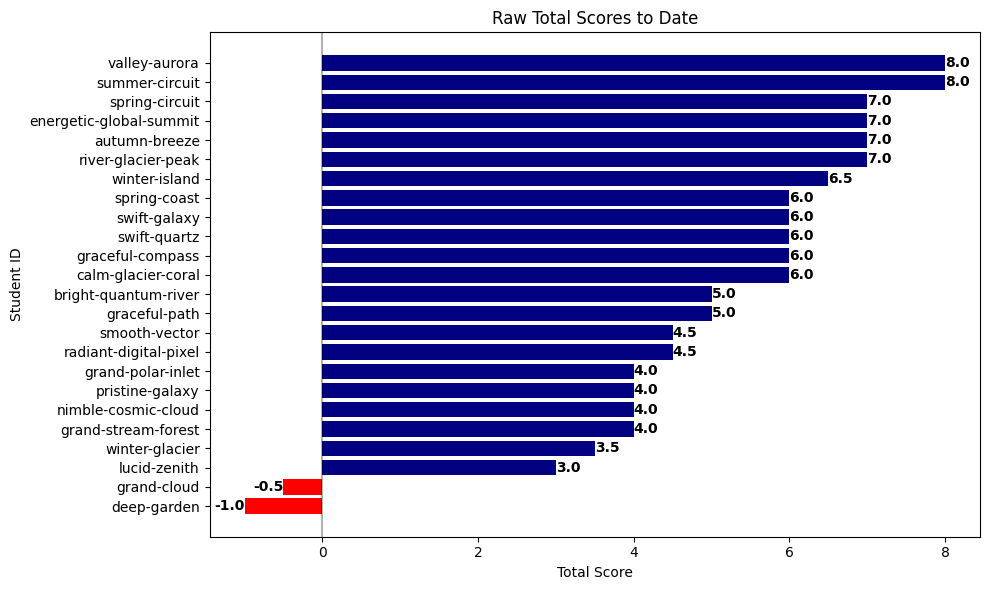

In [25]:
df_participation = final_participation[['public_id','total_score']]
df_weekly = final_weekly[['public_id','total_score']]
merged = df_participation.merge(df_weekly,on="public_id")

score_cols = [col for col in merged.columns if col.startswith("total_score")]
merged["final_score"] = merged[score_cols].sum(axis=1)
merged.sort_values('final_score',inplace=True)

plt.figure(figsize=(10,6))

# Create horizontal bars with different colors for positive/negative
colors = ['red' if x < 0 else 'navy' for x in merged['final_score']]
bars = plt.barh(merged['public_id'], merged['final_score'], color=colors)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add value labels at the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             ha='left' if width >= 0 else 'right',
             va='center',
             fontweight='bold')

plt.title('Raw Total Scores to Date')
plt.xlabel('Total Score')
plt.ylabel('Student ID')
plt.tight_layout()
plt.show()